# Introduction
In this project, we do corner detection and feature matching. We implement [Harris algorithm](http://www.bmva.org/bmvc/1988/avc-88-023.pdf) to do corner detection, and as described in the paper, we use a 2-d Gaussian as a smooth circular window at the second step.  
Then we will implement feature matching based on SSD (sum of squared distnces) and Mutual Marriages.
> Mutual Marraiges: Suppose image ​I1​ yields corners ​d = {(x​1​,y​1)​ , ..., (xn​ ​,y​n​)}​ and image ​I​2​ yields corners ​s = {(x1​ ​,y1​ )​ , ..., (x​m,​ y​m)​ }​. When looking at corner ​d​i​ = (x​i,​ y​i​)​, we look at all of the corners in ​s​ and take the corner with the best SSD match score. Then, we do the same for all features in ​s​ to find the best matches in ​d​. To retrieve ​good​ matches, they must agree, such that if ​di​ ​ finds ​sj​ ​ as its best match, then when searching for matches in ​s​ then ​s​j better also choose ​d​i​ as its best match or this wasn’t a good match. In this way, they agree on each other and we can reduce ambiguous matches and arbitrary distance thresholding.

*Notes about the reference functions and our results: they are just for reference and your results do NOT have to be exactly the same; but when there are some discrepencies, you may want to double check the correctness of your code, make sure your code is doing the right thing while the discrepencies are caused by some trivial details of the implementation, and try to find alternative reference functions to compare with (e.g. cv2.getGaussianKernel for Q2)*

In [1]:
# include necessary packages
from __future__ import print_function
import cv2
import numpy as np
import math
from scipy.ndimage import filters
from scipy import signal
%matplotlib inline
from matplotlib import pyplot as plt
from non_max_suppression import non_max_suppression

In [2]:
# load your solutions
from p2 import *

## Question 1
The Gaussian blur is a type of image-blurring filter that makes use of a Gaussian function. By blurring images first, we can lessen impact of noises when we detect edges.
Here is the 1-D Gaussian function:
\begin{equation*}
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x^2}{2\sigma^2}}
\end{equation*}

However, in this question, you need to apply the Gaussian blur and first order edge detection operater in just one step. And this can be done by simply using a first order Gaussian derivative filter kernel. Please figure out how to get a 1-D first order Gaussian derivative filter kernel from a 1-D Gaussian function.


Write a python function to generate a 1-D first order Gaussian derivative filter kernel.
```python
def gaussian_derivative1d(window_size=5, sigma=1):
    # TODO
    return f
```

Input:
* window_size(scalar): Guassian filter window_size. 5 is the default.
* sigma(scalar): Guassian deviation. 1 is the default.

Output:
* return a 1D numpy array f, of size (window_size,).

Scores: 2

def gaussian_derivative1d(window_size=5, sigma=1):
    f = np.zeros(window_size)
    a = -1*(1/((math.pow(sigma, 3)) * math.sqrt(2*math.pi)))
    variance = sigma**2
    l = window_size/2
    
    for i in range(-l, l + 1):
        f[i + l] = a*i*math.exp(-(float(i**2)/(2*variance)))
    return f

In [3]:
### Verify
from scipy.ndimage import gaussian_filter1d
test_input = np.random.rand(50)
d_gauss1d = gaussian_derivative1d(window_size=31, sigma=1)
scipy_result = gaussian_filter1d(test_input, 1, order=1)
test_result = filters.convolve1d(test_input, d_gauss1d)
assert np.allclose(test_result, -1*scipy_result, atol=1e-05) or np.allclose(test_result, scipy_result, atol=1e-05)


## Question 2
In this question, you need to implement a 2-D Gaussian blur kernel. Since we only give you 1-D Gaussian function, you have to come up with the 2-D Gaussian function and then make it into a 2-D Gaussian blur filter kernel.

Write a python function to generate a 2-D gaussian blur filter kernel.
```python
def gaussian_filter2d(window_shape=(3, 3), sigma=0.5):
    # TODO
    return f
```

Input:
* window_shape(tuple): The shape of Gaussian filter, which is (3, 3) by default.
* sigma(scalar): A scalar which represents the variance for both x and y.

Output:
* return a 2D numpy array f, of size window_shape.

Scores: 2

def gaussian_filter2d(window_shape=(3, 3), sigma=0.5):
    f = np.zeros(window_shape)
    a = (1/(2*math.pi*math.pow(sigma, 2)))
    variance = float(sigma**2)
    l = window_shape[0]/2
    for i in range(-l, l + 1):
        for j in range(-l, l + 1):  
            f[i + l][j + l] = a*math.exp(-((float(i**2) + float(j**2))/(2*variance)))
    sumT = f.sum()
    f = f / sumT
    return f

In [8]:
### Verify
from scipy.ndimage import gaussian_filter
test_input = np.random.rand(5,5)
gauss2d = gaussian_filter2d(window_shape=(11, 11), sigma=0.5)
scipy_result = gaussian_filter(test_input, 0.5, order=0)
test_result = signal.convolve2d(test_input, gauss2d, mode="same", boundary="symm")
print(scipy_result)
print(test_result)
assert np.allclose(test_result, -1*scipy_result, atol=1e-05) or np.allclose(test_result, scipy_result, atol=1e-05)


[[0.621988   0.64529911 0.37975277 0.16922522 0.46446116]
 [0.34358371 0.77864187 0.5395012  0.71612759 0.61104208]
 [0.7143285  0.46409575 0.32869504 0.63720661 0.45082279]
 [0.46034292 0.43727802 0.17775258 0.72319192 0.39132331]
 [0.34057446 0.4552364  0.1928135  0.73973885 0.7541164 ]]
[[0.62198799 0.64529911 0.37975277 0.16922524 0.46446116]
 [0.34358372 0.77864187 0.5395012  0.71612759 0.61104209]
 [0.71432849 0.46409575 0.32869504 0.63720661 0.45082279]
 [0.46034292 0.43727802 0.17775259 0.72319191 0.3913233 ]
 [0.34057447 0.45523641 0.19281352 0.73973885 0.75411639]]


## Question 3
Write a python function to calculate Harris corner. Your function should find at least 100 corners in both provided images, "bikes1.png" and "bikes2.png", to get full points, so you may need to tune parameters in your function for those two images. (You can add additional arguments for convenience because different images may need different parameters.)

```python
def harris_corner(image):
    # TODO
    return pixel_coords
```

Input:
* image (numpy.ndarray): The input image to detect features on. Note: this is NOT the image name or image path.

Output:
* return a list of tuples of pixel_coords. A list of (row,col) tuples of detected feature locations in the image.

Scores: 6

def harris_corner(image):
    pixel_coords = []
    h = np.array((2, 2))
    temp = np.zeros((image.shape[0], image.shape[1]))
    window_size = 5
    sigma = 1
    
    radius = int((window_size - 1)/2)
    padded_img = np.pad(image, radius, 'constant')
    
    h = image.shape[0]
    w = image.shape[1]
    k = 0.06
    threshold = 15000000
    gx = gaussian_derivative1d(window_size, sigma)
    gx = gx.reshape(gx.shape[0], 1)
    gy = gx.reshape(1, gx.shape[0])
    conv_im_x = signal.convolve2d(padded_img, gx, mode="same", boundary="symm")
    conv_im_y = signal.convolve2d(padded_img, gy, mode="same", boundary="symm")
    ix2 = conv_im_x **2
    ixy = conv_im_x * conv_im_y
    iy2 = conv_im_y ** 2
    l = int(window_size/2)
    for i in range(0, h):
        for j in range(0, w):
            xx = ix2[i - l: i + l, j - l: j + l]
            xy = ixy[i - l: i + l, j - l: j + l]
            yy = iy2[i - l: i + l, j - l: j + l]
            sumx2 = xx.sum()
            sumxy = xy.sum()
            sumy2 = yy.sum()           
            det = (sumx2 * sumy2) - (sumxy**2)
            t = sumx2 + sumy2
            r = det - k *(t**2)
            if(r > threshold):
                temp[i][j] = r
    temp = non_max_suppression(temp)
    for i in range(0, temp.shape[0]):
        for j in range(0, temp.shape[1]):
            if temp[i][j] != 0 :
                pixel_coords.append((i, j))
    return pixel_coords

286


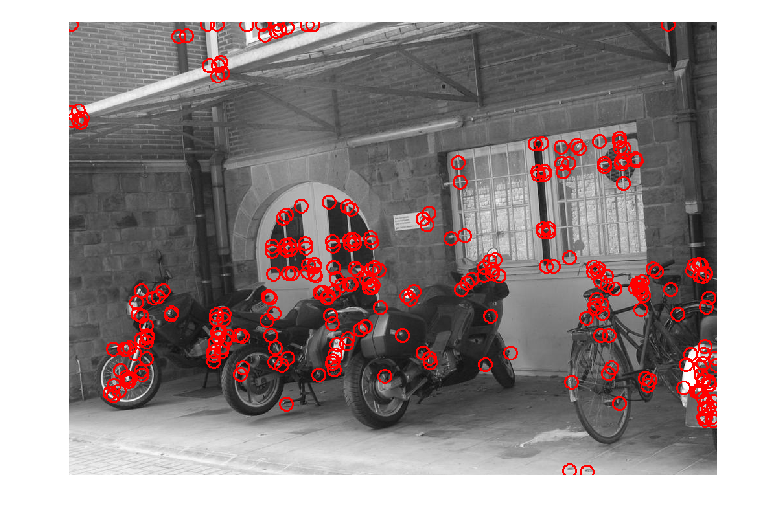

In [6]:
### Verify
img = cv2.imread('bikes1.png', 0)
feature_list = harris_corner(img)
print(len(feature_list))
dis_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in range(len(feature_list)):
    cv2.circle(dis_img, (feature_list[i][1], feature_list[i][0]),
               10, (255,0,0), 2)
plt.imshow(dis_img)
plt.rcParams['figure.dpi'] = 150
plt.axis('off')
plt.show()

212


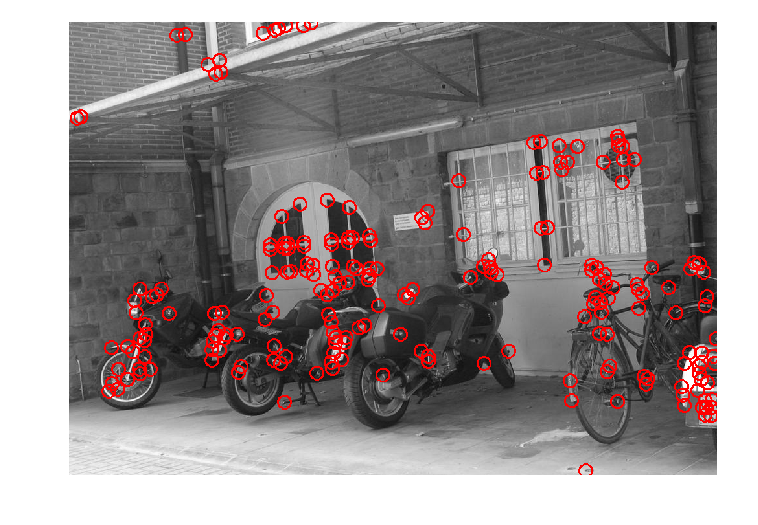

In [19]:
### Verify
img = cv2.imread('bikes1.png', 0)
feature_list = harris_corner(img)
print(len(feature_list))
dis_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in range(len(feature_list)):
    cv2.circle(dis_img, (feature_list[i][1], feature_list[i][0]),
               10, (255,0,0), 2)
plt.imshow(dis_img)
plt.rcParams['figure.dpi'] = 150
plt.axis('off')
plt.show()

## Question 4 (Required for Graduate Students Only)
Write a python function to calculate SSDs to find mutual marriage matching features. There should be at least 30 matching to get full points.

```python
def match_features(feature_coords_1, feature_coords_2, image_1, image_2):
    # TODO
    return matches
```

Input:
* feature_coords_1 (list of tuples): list of (row,col) tuple feature coordinates from image_1
* feature_coords_2 (list of tuples): list of (row,col) tuple feature coordinates from image_2
* image_1 (numpy.ndarray): The input image corresponding to feature_coords_1
* image_2 (numpy.ndarray): The input image corresponding to feature_coords_2

Output:
* return a list of tuples, matches. list of index pairs of possible matches. For example, if the 4-th feature in feature_coords_1 and the 0-th feature in feature_coords_2 are determined to be matches, the list should contain (4,0).

Scores: 4

In [23]:
### Verify
img1 = cv2.imread('bikes1.png', 0)
img2 = cv2.imread('bikes2.png', 0)
feature_list1 = harris_corner(img1)
feature_list2 = harris_corner(img2)
matches = match_features(feature_list1,feature_list2,img1,img2)
print(len(matches))

	Number of matches: 	 31
31


## Question 5 (Required for Graduate Students Only)
Write a python function to display your successfully matching features.
```python
def display_matches(feature_coords_1, feature_coords_2, matches, image_1, image_2):
    # TODO
    return concat_image
```

Input:
* feature_coords_1 (list of tuples): list of (row,col) tuple feature coordinates from image_1
* feature_coords_2 (list of tuples): list of (row,col) tuple feature coordinates from image_2
* matches (list of tuples): list of (feature_coords_1 index, feature_coords_2 index) tuple
* image_1 (numpy.ndarray): The input image corresponding to feature_coords_1
* image_2 (numpy.ndarray): The input image corresponding to feature_coords_2

Output:
* return a numpy array concat_image, of size (H,2*W,3), type np.uint8 and range 0~255. 
    This is the result image that two images are placed side by side horizontally. And 
    we display successfully matching feature positions and draw lines to link them.

Scores: 2

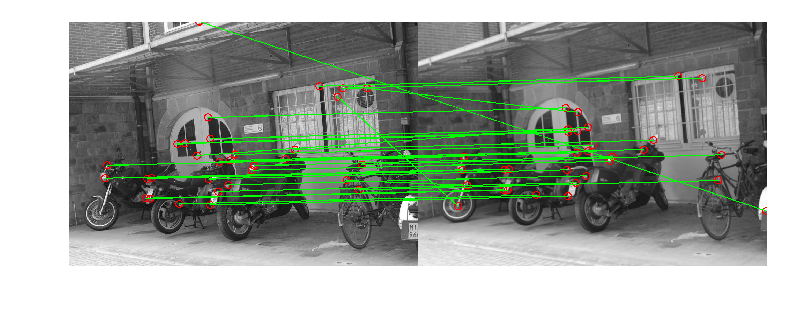

In [25]:
### ### Verify
concat_image = display_matches(feature_list1, feature_list2, matches, img1, img2)
plt.imshow(concat_image)
plt.axis('off')
plt.show()